In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import json
import nltk
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, make_scorer, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
import scipy
import scipy.stats as stats
from keras.optimizers import Adam, SGD
import itertools
import gensim
import gensim.downloader as gensim_api
from ast import literal_eval


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darkling\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darkling\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Darkling\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Reading the Data

We're going to read the metadata file that is a part of our summaries dataset

In [4]:
data = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
# read movie plots

data.columns=['movie_id',1, 'movie_name',3,4,5,6,7, 'genre']
plots=[]

with open('MovieSummaries/plot_summaries.txt', 'r', encoding='utf-8') as file:
    reader = csv.reader(file, dialect='excel-tab')
    for row in tqdm(reader):
        plots.append(row)

42303it [00:01, 22611.50it/s]


In [6]:
#just checking our plots array to see whether it was read fine
print(plots[0])
print(plots[2])


['23890098', "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."]
['20663735', "Poovalli Induchoodan  is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon  was framed in the case by Manapally Madhavan Nambiar  and his crony DYSP Sankaranarayanan  to take revenge on idealist judge Menon who had earlier given jail sentence to Manapally in a corruption case. Induchoodan, who had achieved top rank in Indian Civil Service loses the post and Manapally Sudheeran ([[Saikumar  enters the list of civil service trainees. We learn in flashback that it was Ramakrishnan  the son of Moopil Nair , who had actually killed his classmate. Six years passes by and Manapally Madhavan Nambiar, now a former state minister, is dead and Induchoodan, who is all rage at the gross injustice meted out to him -

# Arranging data into needed format

## Converting the text file of Plots into a Data Frame

In [7]:
movie_id=[]
plot=[]

for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

movies = pd.DataFrame({'movie_id':movie_id, 'synopsis':plot})

100%|████████████████████████████████████████████████████████████████████████| 42303/42303 [00:00<00:00, 915889.67it/s]


In [8]:
movies.head()

,movie_id,synopsis
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Merging movie plots and genres

In [9]:
data['movie_id']= data['movie_id'].astype(str)
movies = pd.merge(movies, data[['movie_id', 'movie_name', 'genre']], on='movie_id')

movies.head()

,movie_id,synopsis,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


## Converting Genres from JSON to List

As we can see in the above dataset that genre column contains JSON objects which have data in form of key-value pairs but we are only interested in having the genres of the related plot. SO lets convert this JSON to simple list format containing genres

In [10]:
genres=[]

for i in movies['genre']:
    genres.append(list(json.loads(i).values()))

movies['genre_new']= genres

In [11]:
movies.head()   
# PS. dont get annoyed by frequent calling of this function.... it helps see errors :)

,movie_id,synopsis,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


In [12]:
data = movies[~(movies['genre_new'].str.len()==0)]
data.shape, movies.shape

((41793, 5), (42204, 5))

In [13]:
data.head()

,movie_id,synopsis,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


# Starting NLP Operations

In case of language modelling and NLP, frequency and count of words holds a lot of importance along with its connotation. So, we will be starting our NLP Operations by doing these calculations first.

In [14]:
genres_list = sum(genres, [])
print("Number of genres: "+ str(len(set(genres_list))))

Number of genres: 363


In [15]:
genres_freq = nltk.FreqDist(genres_list)
genres_list = pd.DataFrame({'Genre': list(genres_freq.keys()), 'Count':list(genres_freq.values()) })
genres_list = genres_list[genres_list['Count']<1000]
genres_list.describe()

,Count
count,330.000000
mean,109.921212
std,180.728885
min,1.000000
25%,6.000000
50%,29.000000
75%,115.250000
max,998.000000


In [16]:
# removing genres other than most frequent genres

bottom_genres = genres_list['Genre'].tolist()+['Silent film', 'Indie', 'Comedy-drama', 'Comedy film','Film adaptation', 'Black-and-white'  ]
data['genre_new']= data.genre_new.apply(lambda x: [i for i in x if i not in bottom_genres])
data.head()

,movie_id,synopsis,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",[Comedy]
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, World cinema]"


In [17]:
# removing data gaving NULL genre list

data = data[data['genre_new'].map(lambda x: len(x)>0)]
data.head()

,movie_id,synopsis,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",[Comedy]
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, World cinema]"


In [18]:
genres=[]

for i in data['genre_new']:
    genres.append(i)

genres_list= sum(genres, [])
print("Number of genres: "+ str(len(set(genres_list))))

Number of genres: 27


In [19]:
genres_freq = nltk.FreqDist(genres_list)
genres_list = pd.DataFrame({'Genre': list(genres_freq.keys()), 'Count':list(genres_freq.values()) })

# Plotting the top Genres

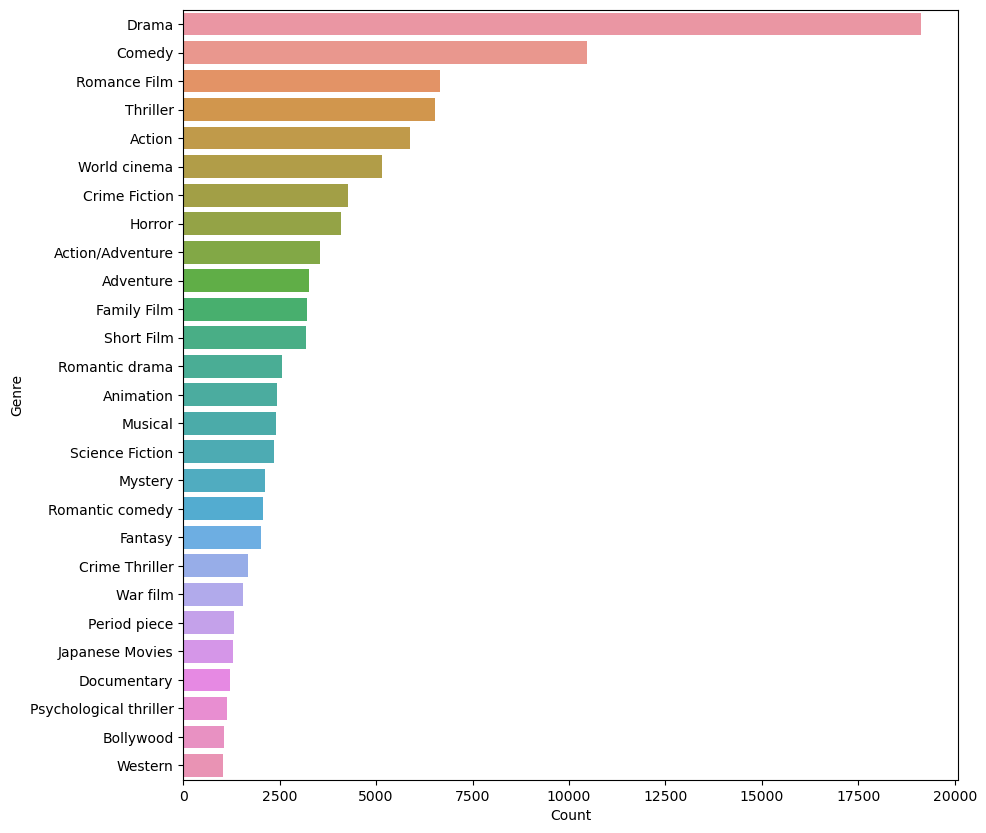

In [20]:
g = genres_list.nlargest(columns='Count', n=33)
plt.figure(figsize = (10,10))
graph= sns.barplot(data=g, x='Count', y='Genre')
graph.set(ylabel='Genre')
plt.show()


# Data Preprocessing

In NLP, mostly data preprocessing includes removing unwanted symbols, characters and words. Doing this ensures that we only have the meaningful data with us and model is more efficient.

### Removing numbers, puncuations and symbols

In [21]:
def filter_synopsis(synopsis):
    synopsis = re.sub("\ '","", synopsis)
    synopsis = re.sub("[^a-zA-Z]", " ", synopsis)
    synopsis = ' '.join(synopsis.split())
    synopsis = synopsis.lower()
    return synopsis


In [22]:
data['plot'] = data['synopsis'].apply(lambda x: filter_synopsis(x))
data.head()

,movie_id,synopsis,movie_name,genre,genre_new,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",shlykov a hard working taxi driver and lyosha ...
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr...",the nation of panem consists of a wealthy capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]",poovalli induchoodan is sentenced for six year...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",[Comedy],the lemon drop kid a new york city swindler is...
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, World cinema]",seventh day adventist church pastor michael ch...


Now in the above output you can see the difference between 'synopsis' column and 'plot' column

### Finding the frequencies of top 50 most occuring words

In [23]:
def word_frequency(col, items):
    text = ' '.join([plot for plot in col])
    text = text.split()
    freq_dist = nltk.FreqDist(text)
    
    words_df = pd.DataFrame({'Word':list(freq_dist.keys()), 'Frequency':list(freq_dist.values())  })

    # plotting the frequency along with words
    order= words_df.nlargest(columns='Frequency',n=items)
    plt.figure(figsize=(10,10))
    graph = sns.barplot(data=order, x='Frequency', y='Word')
    plt.show()

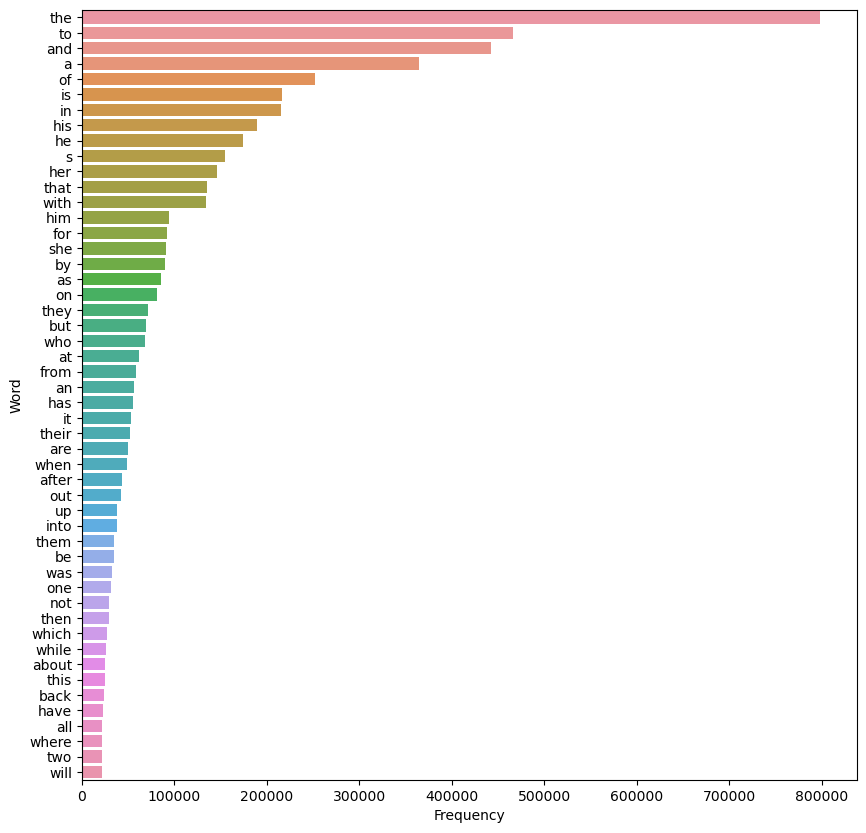

In [24]:
word_frequency(data['plot'],50)


Now we can see that these words are meaningless but are so much in frequency that if we process them our model will waste a lot of time in processing the data that will NOT contribute anything to predicting the genre of our movies. Such words are called *Stop Words* and need to to be removed.

### Stop Word Removal

In [25]:
eng_stopwords = set(stopwords.words('english'))

def stopwords_filtering(plot):
    filtered_text = [x for x in plot.split() if not x in eng_stopwords]
    return ' '.join(filtered_text)
    

In [26]:
data['plot']= data['plot'].apply(lambda x: stopwords_filtering(x))
data.head()

,movie_id,synopsis,movie_name,genre,genre_new,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",shlykov hard working taxi driver lyosha saxoph...
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr...",nation panem consists wealthy capitol twelve p...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]",poovalli induchoodan sentenced six years priso...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",[Comedy],lemon drop kid new york city swindler illegall...
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, World cinema]",seventh day adventist church pastor michael ch...


We will again print the word-frequency graph to see if stop words have been removed

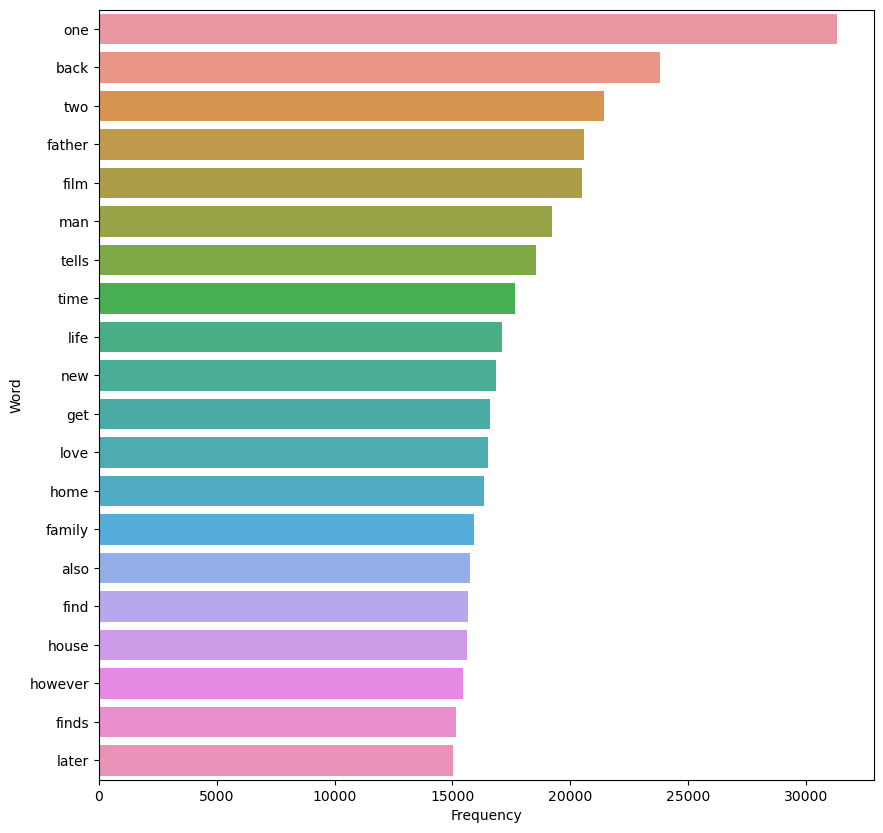

In [27]:
word_frequency(data['plot'],20)

### Word Lemmatization

In [28]:
def lemma_plot(plot):
    lemmatizer = WordNetLemmatizer()
    filtered_text= [ lemmatizer.lemmatize(x) for x in plot.split() ]
    return ' '.join(filtered_text)

In [29]:
data['plot']= data['plot'].apply(lambda x: lemma_plot(x))
data.head()

,movie_id,synopsis,movie_name,genre,genre_new,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",shlykov hard working taxi driver lyosha saxoph...
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr...",nation panem consists wealthy capitol twelve p...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]",poovalli induchoodan sentenced six year prison...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",[Comedy],lemon drop kid new york city swindler illegall...
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, World cinema]",seventh day adventist church pastor michael ch...


In [30]:
# saving the data
data.to_csv('dataset1.csv')

# Feature Engineering and Model Development

In [31]:
data = pd.read_csv('dataset1.csv')
data.head()

,Unnamed: 0,movie_id,synopsis,movie_name,genre,genre_new,plot
0,0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","['Drama', 'World cinema']",shlykov hard working taxi driver lyosha saxoph...
1,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","['Action/Adventure', 'Science Fiction', 'Actio...",nation panem consists wealthy capitol twelve p...
2,2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","['Musical', 'Action', 'Drama', 'Bollywood']",poovalli induchoodan sentenced six year prison...
3,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",['Comedy'],lemon drop kid new york city swindler illegall...
4,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","['Crime Fiction', 'Drama', 'World cinema']",seventh day adventist church pastor michael ch...


### Coverting string to list

In [32]:
data['genre_new']= data['genre_new'].apply(lambda x: literal_eval(x))

### Quantifying the Labels

In [33]:
binarizer = MultiLabelBinarizer()
binarizer.fit(data['genre_new'])
y = binarizer.transform(data['genre_new'])
binarizer.classes_

array(['Action', 'Action/Adventure', 'Adventure', 'Animation',
       'Bollywood', 'Comedy', 'Crime Fiction', 'Crime Thriller',
       'Documentary', 'Drama', 'Family Film', 'Fantasy', 'Horror',
       'Japanese Movies', 'Musical', 'Mystery', 'Period piece',
       'Psychological thriller', 'Romance Film', 'Romantic comedy',
       'Romantic drama', 'Science Fiction', 'Short Film', 'Thriller',
       'War film', 'Western', 'World cinema'], dtype=object)

### Tf-idf Vectorization

In [34]:
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(data['plot'])
print(x_tfidf.shape, y.shape )

(40103, 126088) (40103, 27)


### Count Vecotrization

In [35]:
bow_vectorizer = CountVectorizer()
x_bow = bow_vectorizer.fit_transform(data['plot'])
print(x_bow.shape, y.shape)

(40103, 126088) (40103, 27)


### Tf-idf models with full dataset

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_tfidf,y,test_size=0.2,random_state=42)


### Using Logistic Regression

In [37]:
lr_tfidf = LogisticRegression()
clf_tfidf = OneVsRestClassifier(lr_tfidf)
clf_tfidf.fit(x_train,y_train)
tfidf_pred = clf_tfidf.predict(x_test)
print(classification_report(y_test, tfidf_pred, target_names = binarizer.classes_))

                        precision    recall  f1-score   support

                Action       0.75      0.21      0.33      1201
      Action/Adventure       0.59      0.07      0.13       731
             Adventure       0.76      0.08      0.14       676
             Animation       0.77      0.23      0.36       532
             Bollywood       0.50      0.02      0.05       209
                Comedy       0.75      0.30      0.43      2063
         Crime Fiction       0.60      0.13      0.21       850
        Crime Thriller       0.39      0.02      0.04       316
           Documentary       0.94      0.13      0.23       256
                 Drama       0.73      0.71      0.72      3827
           Family Film       0.71      0.16      0.27       634
               Fantasy       0.67      0.03      0.06       425
                Horror       0.92      0.35      0.50       796
       Japanese Movies       0.96      0.08      0.15       273
               Musical       0.57      

### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

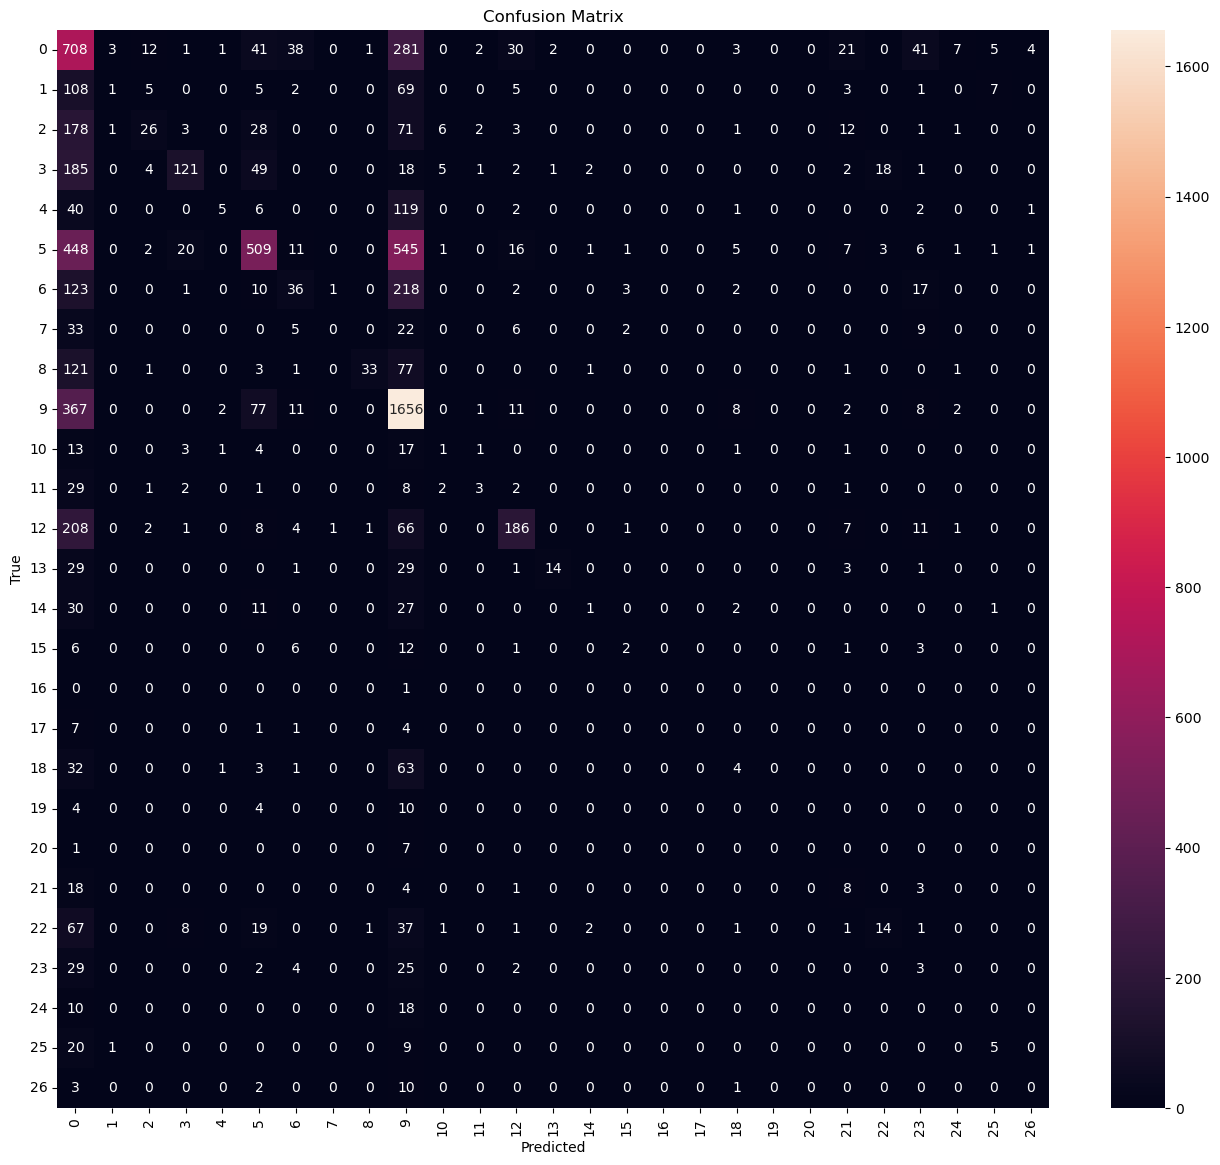

In [38]:
y_pred = np.argmax(tfidf_pred, axis=1)
y_true = np.argmax(y_test, axis=-1)
cm = confusion_matrix(y_true, y_pred)

labels = binarizer.classes_
class_names=labels

fig = plt.figure(figsize=(16,14))
graph = plt.subplot()
sns.heatmap(cm, annot=True, ax=graph, fmt='g')
graph.set_xlabel('Predicted')
graph.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
#graph.xaxis.set_tickables(class_names)
graph.xaxis.tick_bottom()

graph.set_ylabel('True')
#graph.yaxis.set_tickables(class_names)
plt.yticks(rotation=0)

plt.title('Confusion Matrix')

### Decision Tree Classifier

In [39]:
dt_tfidf = DecisionTreeClassifier(max_depth=8)
clf_tfidf = OneVsRestClassifier(dt_tfidf)
clf_tfidf.fit(x_train,y_train)
tfidf_pred = clf_tfidf.predict(x_test)
print(classification_report(y_test, tfidf_pred, target_names = binarizer.classes_))

                        precision    recall  f1-score   support

                Action       0.55      0.16      0.25      1201
      Action/Adventure       0.43      0.12      0.19       731
             Adventure       0.57      0.14      0.22       676
             Animation       0.66      0.26      0.37       532
             Bollywood       0.42      0.09      0.14       209
                Comedy       0.58      0.08      0.14      2063
         Crime Fiction       0.44      0.13      0.20       850
        Crime Thriller       0.31      0.07      0.11       316
           Documentary       0.62      0.32      0.42       256
                 Drama       0.63      0.48      0.54      3827
           Family Film       0.54      0.12      0.20       634
               Fantasy       0.47      0.10      0.16       425
                Horror       0.68      0.30      0.42       796
       Japanese Movies       0.68      0.30      0.42       273
               Musical       0.34      

### Logistic Regression Using Bag of Words

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x_bow,y,test_size=0.2,random_state=42)

In [41]:
lr_bow = LogisticRegression()
clf_bow = OneVsRestClassifier(lr_bow)
clf_bow.fit(x_train,y_train)
bow_pred = clf_bow.predict(x_test)
print(classification_report(y_test, bow_pred, target_names = binarizer.classes_))

                        precision    recall  f1-score   support

                Action       0.52      0.42      0.47      1201
      Action/Adventure       0.47      0.35      0.40       731
             Adventure       0.52      0.38      0.44       676
             Animation       0.65      0.45      0.54       532
             Bollywood       0.34      0.22      0.26       209
                Comedy       0.56      0.49      0.52      2063
         Crime Fiction       0.47      0.36      0.41       850
        Crime Thriller       0.30      0.23      0.26       316
           Documentary       0.75      0.44      0.55       256
                 Drama       0.68      0.67      0.68      3827
           Family Film       0.51      0.38      0.44       634
               Fantasy       0.49      0.30      0.37       425
                Horror       0.78      0.62      0.69       796
       Japanese Movies       0.64      0.38      0.48       273
               Musical       0.34      

As the classification reports of all models show that using Logistic Regression with Tf-idf has better classification report, we will further enhance and use it.

### Dimensionality Reduction using SVD for Logistic Regression

In [42]:
svd = TruncatedSVD(n_components=350, n_iter=7, random_state=42)
svd.fit(x_tfidf)
svd_vec = svd.transform(x_tfidf)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(svd_vec, y, test_size=0.2, random_state=42)
lr_tfidfsvd = LogisticRegression()
clf_tfidfsvd = OneVsRestClassifier(lr_tfidfsvd)
clf_tfidfsvd.fit(x_train,y_train)
tfidfsvd_pred = clf_tfidfsvd.predict(x_test)
print(classification_report(y_test, tfidfsvd_pred, target_names = binarizer.classes_))

                        precision    recall  f1-score   support

                Action       0.72      0.19      0.31      1201
      Action/Adventure       0.51      0.07      0.12       731
             Adventure       0.74      0.06      0.12       676
             Animation       0.76      0.23      0.35       532
             Bollywood       0.64      0.03      0.06       209
                Comedy       0.68      0.25      0.36      2063
         Crime Fiction       0.59      0.13      0.22       850
        Crime Thriller       0.44      0.02      0.04       316
           Documentary       0.94      0.11      0.20       256
                 Drama       0.71      0.68      0.69      3827
           Family Film       0.69      0.15      0.25       634
               Fantasy       0.73      0.04      0.07       425
                Horror       0.88      0.33      0.48       796
       Japanese Movies       0.88      0.05      0.10       273
               Musical       0.48      

In [44]:
data1 = data.sample(frac=0.1)
data1.head()

,Unnamed: 0,movie_id,synopsis,movie_name,genre,genre_new,plot
37930,39930,35004788,This documentary connects two artistic traject...,Die Tunisreise,"{""/m/0jtdp"": ""Documentary""}",[Documentary],documentary connects two artistic trajectory b...
9758,10297,14930873,The film follows the recently demobilized Serg...,I am Twenty,"{""/m/07s9rl0"": ""Drama""}",[Drama],film follows recently demobilized sergei young...
31890,33616,2511602,The film opens with John Dolittle as a child t...,Dr. Dolittle,"{""/m/0hqxf"": ""Family Film"", ""/m/0hj3n2s"": ""Fan...","[Family Film, Comedy]",film open john dolittle child talking dog asks...
22107,23304,16166532,Selvarasu is the head of the family and his t...,Samudhiram,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",selvarasu head family two brother ready give l...
21915,23103,2918399,The story is told from the point of view of Am...,Virrudh... Family Comes First,"{""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood...","[Drama, Bollywood, World cinema]",story told point view amar amar son vidyadhar ...


In [45]:
binarizer1 = MultiLabelBinarizer()
binarizer1.fit(data1['genre_new'])
y1 = binarizer1.transform(data1['genre_new'])
y1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Dimensionality Reduction Using SVD for BoW

In [46]:
svd = TruncatedSVD(n_components=350, n_iter=7, random_state=42)
svd.fit(x_bow)
svd_vec = svd.transform(x_bow)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(svd_vec,y,test_size=0.2,random_state=42)

In [48]:
lr_bowsvd = LogisticRegression()
clf_bowsvd = OneVsRestClassifier(lr_bowsvd)
clf_bowsvd.fit(x_train,y_train)
bowsvd_pred = clf_bowsvd.predict(x_test)
print(classification_report(y_test, bowsvd_pred, target_names = binarizer.classes_))

                        precision    recall  f1-score   support

                Action       0.65      0.25      0.36      1201
      Action/Adventure       0.57      0.20      0.30       731
             Adventure       0.62      0.24      0.34       676
             Animation       0.58      0.28      0.38       532
             Bollywood       0.40      0.16      0.23       209
                Comedy       0.64      0.22      0.33      2063
         Crime Fiction       0.61      0.22      0.32       850
        Crime Thriller       0.33      0.10      0.15       316
           Documentary       0.60      0.23      0.33       256
                 Drama       0.70      0.62      0.66      3827
           Family Film       0.65      0.26      0.37       634
               Fantasy       0.57      0.20      0.29       425
                Horror       0.74      0.40      0.52       796
       Japanese Movies       0.49      0.13      0.20       273
               Musical       0.47      

In [50]:
data1 = data.sample(frac=0.1)
data1.head()

,Unnamed: 0,movie_id,synopsis,movie_name,genre,genre_new,plot
37824,39821,28526527,A young man is distraught after losing his fia...,Spellbound,"{""/m/07s9rl0"": ""Drama""}",[Drama],young man distraught losing fianc e terminal i...
3542,3718,22513789,Prince-heir Saliya gives up the throne to marr...,Asokamala,"{""/m/02p0szs"": ""Historical fiction"", ""/m/07s9r...",[Drama],prince heir saliya give throne marry commoner ...
16183,17077,887164,"In London, during the early 1900s, aspiring jo...",The Assassination Bureau,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...","[Crime Fiction, Thriller, Action/Adventure, Co...",london early aspiring journalist woman right c...
9423,9940,417479,La Nuit Américaine chronicles the production o...,Day for Night,"{""/m/01t_vv"": ""Comedy-drama"", ""/m/02l7c8"": ""Ro...","[Romance Film, Drama, Comedy, World cinema]",la nuit ricaine chronicle production je vous p...
26549,27978,10933452,The leader of the Kong Tung clan is Yen Chan Y...,Unbeaten 28,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/04t2t"":...","[Action/Adventure, World cinema]",leader kong tung clan yen chan ying ruthless w...


In [51]:
binarizer = MultiLabelBinarizer()
binarizer.fit(data['genre_new'])
y = binarizer.transform(data['genre_new'])
y

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [74]:
data = pd.read_csv('dataset1.csv')
data['genre_new'] = data['genre_new'].apply(lambda x: literal_eval(x))

binarizer= MultiLabelBinarizer()
binarizer.fit(data['genre_new'])
y = binarizer.transform(data['genre_new'])
y

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Checking Model

In [106]:
# BOW Vectorizer

bow_vec = CountVectorizer()
x_bow = bow_vec.fit_transform(data['plot'])
print(x_bow.shape,y.shape)

(40103, 126088) (40103, 27)


In [107]:
svd_bow = TruncatedSVD(n_components = 350, n_iter=7, random_state=42)
svd_bow.fit(x_bow)
svd_vec= svd_bow.transform(x_bow)

In [113]:
plot = """In a future choked by dust storms and dying crops, Cooper, a former NASA pilot, tends his farm with his daughter Murph. Blight threatens humanity's survival. Cooper discovers a hidden NASA facility working on a last-ditch effort: a mission through a wormhole near Saturn to find a new home for humanity.Torn between responsibility and leaving his children behind, Cooper joins the crew. They travel to planets warped by the nearby black hole Gargantua. Plan A involves using data from one planet to develop a way for humanity to escape Earth's gravity. Plan B is finding a colony on a suitable planet.The team faces danger and sacrifice. Cooper, stranded on a watery world, uses gravity assist to launch a teammate towards data collection. Back on Earth, Murph becomes a scientist, deciphering cryptic messages Cooper sends through a wormhole anomaly in her childhood room.Time dilation near Gargantua throws a wrench in their plans. Years pass for the astronauts while mere hours tick by on Earth. We learn the wormhole itself was created by future humans using the knowledge from this mission, a bootstrap paradox. Cooper, trapped inside Gargantua, uses the "tesseract" (the fifth dimension) to communicate with Murph across time, giving her the final piece of the equation for Plan A. He escapes Gargantua and rejoins humanity, now living in space thanks to Murph's solution. Aged by time dilation, Cooper reunites with a dying Murph. Despite the hardships, humanity has a future among the stars, a testament to the enduring power of love and scientific exploration."""


In [115]:

text = filter_synopsis(plot)
text = stopwords_filtering(text)
text = lemma_plot(text)
text

'future choked dust storm dying crop cooper former nasa pilot tends farm daughter murph blight threatens humanity survival cooper discovers hidden nasa facility working last ditch effort mission wormhole near saturn find new home humanity torn responsibility leaving child behind cooper join crew travel planet warped nearby black hole gargantua plan involves using data one planet develop way humanity escape earth gravity plan b finding colony suitable planet team face danger sacrifice cooper stranded watery world us gravity assist launch teammate towards data collection back earth murph becomes scientist deciphering cryptic message cooper sends wormhole anomaly childhood room time dilation near gargantua throw wrench plan year pas astronaut mere hour tick earth learn wormhole created future human using knowledge mission bootstrap paradox cooper trapped inside gargantua us tesseract fifth dimension communicate murph across time giving final piece equation plan escape gargantua rejoins hu

In [116]:
bow_text = bow_vec.transform([text])
bow_svd_text = svd_bow.transform(bow_text)


In [117]:
print("Model Output", binarizer.inverse_transform(clf_bowsvd.predict(bow_svd_text)))

Model Output [('Science Fiction',)]


Hence, our model is predicting genre correctly